<a href="https://colab.research.google.com/github/greesh29gg/Data-Driven-Trader-Sentiment-Study/blob/main/Source_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Summary Metrics (by sentiment):

               Closed PnL               Size USD Execution Price
                     mean           std     mean            mean
classification                                                  
fear            747726.88  2.594869e+08  6762.17        10650.55
greed               55.46  9.275200e+02  4221.48         8575.75
neutral             27.28  4.825900e+02  4419.32        10609.86


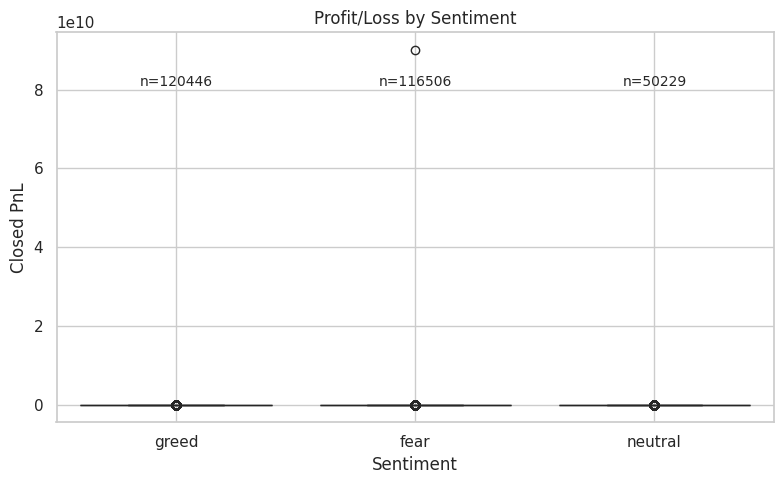

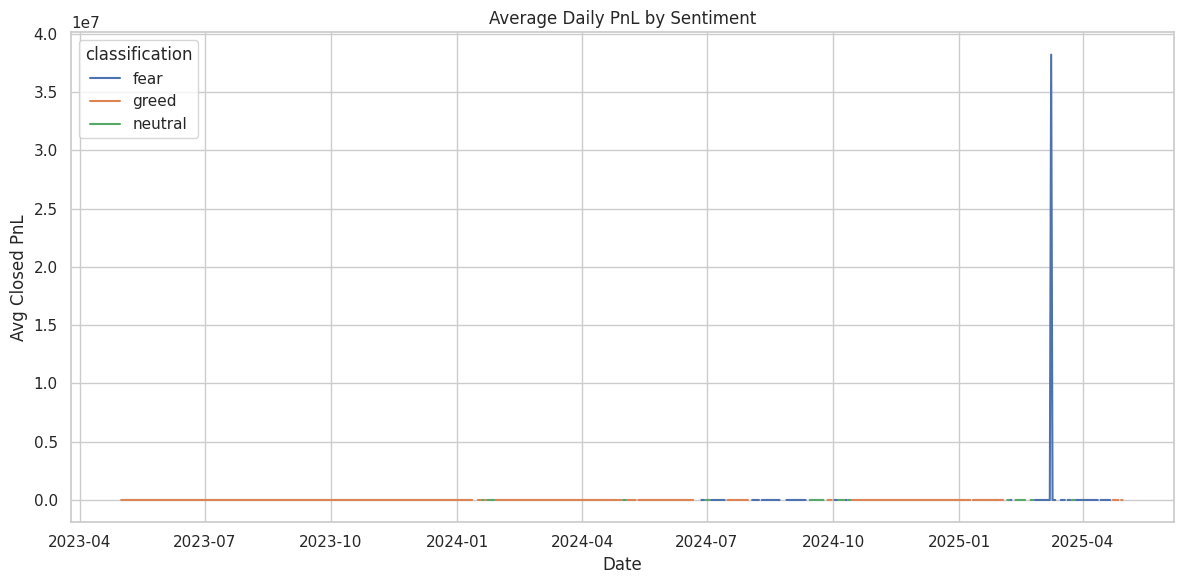


Volatility (PnL std dev) by Sentiment:
 classification
fear       2.594869e+08
greed      9.275181e+02
neutral    4.825913e+02
Name: Closed PnL, dtype: float64


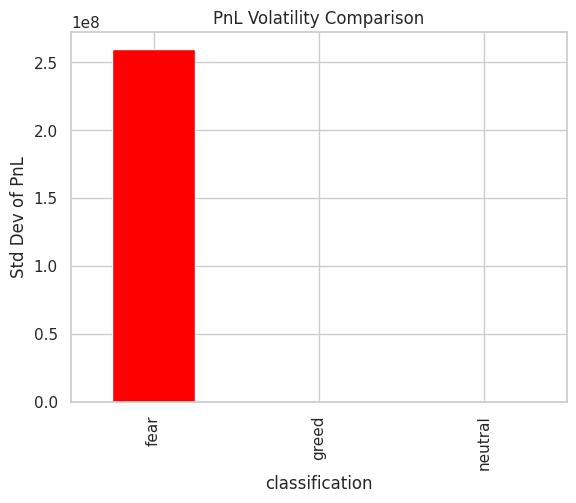


T-test: t = -1.00, p = 0.3173
No significant difference found.

Average PnL by Sentiment & Trade Size:

size_class      small       large
classification                   
fear             2.60  1375264.47
greed            6.09      112.51
neutral          2.07       54.73

Profit Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.90      0.89     50571
           1       0.85      0.81      0.83     35584

    accuracy                           0.86     86155
   macro avg       0.86      0.86      0.86     86155
weighted avg       0.86      0.86      0.86     86155



In [21]:

 #  Import required modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#  Load input files
data_sentiment = pd.read_csv('/content/fear_greed_index.csv')
data_trades = pd.read_csv('/content/historical_data.csv', on_bad_lines='skip', low_memory=False)

#  Clean sentiment data
sentiment_clean = data_sentiment.copy()
sentiment_clean['date'] = pd.to_datetime(sentiment_clean['date']).dt.date
sentiment_clean['classification'] = sentiment_clean['classification'].str.lower()
sentiment_clean['classification'] = sentiment_clean['classification'].replace({
    'extreme fear': 'fear',
    'extreme greed': 'greed'
})

# Fix trade timestamps
data_trades['Timestamp IST'] = pd.to_datetime(data_trades['Timestamp IST'], errors='coerce', dayfirst=True)
data_trades['date'] = data_trades['Timestamp IST'].dt.date

#  Fix numeric columns
for metric in ['Closed PnL', 'Size USD', 'Execution Price']:
    data_trades[metric] = pd.to_numeric(data_trades[metric], errors='coerce')

#  Combine by date
combined = pd.merge(data_trades, sentiment_clean, on='date', how='inner')

#  Summarize
summary_view = combined.groupby('classification').agg({
    'Closed PnL': ['mean', 'std'],
    'Size USD': 'mean',
    'Execution Price': 'mean'
})
print("\nSummary Metrics (by sentiment):\n")
print(summary_view.round(2))

#  Visualize PnL differences
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
colors = {'fear': 'red', 'greed': 'green', 'neutral': 'blue'} # Added 'neutral' to the palette
sns.boxplot(x='classification', y='Closed PnL', data=combined, palette=colors, hue='classification', legend=False)
count_data = combined['classification'].value_counts()
for idx, category in enumerate(count_data.index):
    plt.text(idx, combined['Closed PnL'].max() * 0.9, f"n={count_data[category]}", ha='center', fontsize=10)
plt.title('Profit/Loss by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Closed PnL')
plt.tight_layout()
plt.grid(True)
plt.show()

#  Trend by day
daily_avg = combined.groupby(['date', 'classification'], observed=False)['Closed PnL'].mean().unstack()
daily_avg.plot(figsize=(12, 6))
plt.title('Average Daily PnL by Sentiment')
plt.ylabel('Avg Closed PnL')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

#  Volatility analysis
pnl_vol = combined.groupby('classification').agg({'Closed PnL': 'std'}).iloc[:, 0]
print("\nVolatility (PnL std dev) by Sentiment:\n", pnl_vol)

# Bar chart
pnl_vol.plot(kind='bar', color=['red', 'green'])
plt.title('PnL Volatility Comparison')
plt.ylabel('Std Dev of PnL')
plt.grid(True)
plt.show()

#  T-test
fear_sample = combined[combined['classification'] == 'fear']['Closed PnL'].dropna()
greed_sample = combined[combined['classification'] == 'greed']['Closed PnL'].dropna()

stat, p = ttest_ind(greed_sample, fear_sample, equal_var=False)
print(f"\nT-test: t = {stat:.2f}, p = {p:.4f}")
if p < 0.05:
    print("Significant difference in PnL between fear and greed.")
else:
    print("No significant difference found.")

# Segment PnL by trade size
combined['size_class'] = pd.qcut(combined['Size USD'], 2, labels=['small', 'large'])
pnl_segment = combined.groupby(['classification', 'size_class'], observed=False)['Closed PnL'].mean().unstack()
print("\nAverage PnL by Sentiment & Trade Size:\n")
print(pnl_segment.round(2))

# Prediction model
combined['profitable'] = (combined['Closed PnL'] > 0).astype(int)
predictors = combined[['Size USD', 'Execution Price']].copy()
predictors['sentiment_score'] = (combined['classification'] == 'greed').astype(int)
predictors = predictors.fillna(0)

X_data = predictors
y_data = combined['profitable']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predicted = model.predict(X_test)
print("\nProfit Classification Report:\n")
print(classification_report(y_test, predicted))

